In [1]:
!wget https://misc.lysiak.ovh/training_datasets_3.tar.gz

--2021-04-11 19:54:35--  https://misc.lysiak.ovh/training_datasets_3.tar.gz
Resolving misc.lysiak.ovh (misc.lysiak.ovh)... 51.38.129.250
Connecting to misc.lysiak.ovh (misc.lysiak.ovh)|51.38.129.250|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 249398383 (238M) [application/gzip]
Saving to: ‘training_datasets_3.tar.gz’

training_datasets_3 100%[===================>] 237.84M  15.7MB/s    in 14s     

2021-04-11 19:54:50 (17.2 MB/s) - ‘training_datasets_3.tar.gz’ saved [249398383/249398383]

wget https://misc.lysiak.ovh/training_datasets_4.tar.gz


In [2]:
!for f in `ls training_datasets*`; do tar xzf $f; done

In [3]:
!ls training_datasets

5


In [4]:
'''
    Dynamic dataset generatioin.
    Copyrights (c) 2021 Jacek Łysiak
'''

import os
import random
import cv2
import numpy as np

class DatasetGenerator:
    def __init__(self, corrections, *dataset_paths, no_shuffle=False,
            limit_examples=0, print_log=False, start=0., stop=1.):
        assert type(corrections) is tuple
        assert len(corrections) == 2
        self._corrections = corrections
        assert len(dataset_paths) > 0
        self._dataset_paths = list(dataset_paths)
        self._no_shuffle = no_shuffle
        self._limit_examples = limit_examples
        self._print_log = print_log
        self._start = start
        self._stop = stop
        self._shape = self._extract_shape()
        self._load_info()
    
    def _extract_shape(self):
        cs, _, _, _ = self._load_dataset_info(self._dataset_paths[0])
        path = cs[0]
        img = cv2.imread(path)
        return tuple(img.shape)

    def _load_dataset_info(self, path):
        angles_path = os.path.join(path, 'angle.csv')
        cs_path = os.path.join(path, 'center')
        ls_path = os.path.join(path, 'left')
        rs_path = os.path.join(path, 'right')
        with open(angles_path) as f:
            angles = list(map(float, f.read().split()))
        cs = [os.path.join(cs_path, x) for x in os.listdir(cs_path)]
        ls = [os.path.join(ls_path, x) for x in os.listdir(ls_path)]
        rs = [os.path.join(rs_path, x) for x in os.listdir(rs_path)]
        cs.sort()
        ls.sort()
        rs.sort()
        n = len(cs)
        idx_start = int(n * self._start)
        idx_stop = int(n * self._stop)
        cs = cs[idx_start:idx_stop]
        ls = ls[idx_start:idx_stop]
        rs = rs[idx_start:idx_stop]
        angles = angles[idx_start:idx_stop]
        if self._limit_examples > 0:
            cs = cs[:self._limit_examples]
            ls = ls[:self._limit_examples]
            rs = rs[:self._limit_examples]
            angles = angles[:self._limit_examples]
        return cs, ls, rs, angles
    
    def _load_info(self):
        # get all (img, angle)
        examples = []
        for dataset_path in self._dataset_paths:
            cs, ls, rs, angles = self._load_dataset_info(dataset_path)
            # Add non-flipped imgs
            flipped = [False] * len(angles)
            examples.extend(zip(cs, angles, flipped))
            examples.extend(zip(ls, [a + self._corrections[0] for a in angles], flipped))
            examples.extend(zip(rs, [a + self._corrections[1] for a in angles], flipped))
            # Add flipped
            flipped = [True] * len(angles)
            examples.extend(zip(cs, [-a for a in angles], flipped))
            examples.extend(zip(ls, [-a - self._corrections[0] for a in angles], flipped))
            examples.extend(zip(rs, [-a - self._corrections[1] for a in angles], flipped))
        self._examples = examples
        self._size = len(examples)
        
    def shuffle(self):
        random.shuffle(self._examples)

    def __iter__(self):
        if not self._no_shuffle:
            self.shuffle()
        self._idx = 0
        return self

    def __len__(self):
        return self._size
    
    def _load_example(self, idx):
        path, angle, flip = self._examples[idx]
        if self._print_log:
            print('Next up: ', path, angle, flip)
        img = cv2.imread(path)
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        if flip:
            img = img[:,::-1,:]
        return img, angle
        
    def __next__(self):
        # Get next image from dataset
        if self._idx < self._size:
            img, angle = self._load_example(self._idx)
            self._idx += 1
            return img, angle
        else:
            raise StopIteration
            
    def __getitem__(self, args):
        if type(args) is slice:
                imgs =  []
                angles = []
                for idx in range(args.start, args.stop):
                    img, a = self._load_example(idx)
                    imgs.append(img)
                    angles.append(a)
                return np.array(imgs), np.array(angles)
        else:
            idx = args[0]
            return self._load_example(idx)

    @property
    def shape(self):
        return self._shape

In [5]:
import tensorflow as tf


class SimSequence(tf.keras.utils.Sequence):
    '''Keras wrapper for our images generator.'''
    def __init__(self, batch_size, corrections, *datasets, start=0.,  stop=1.):
        self._generator = DatasetGenerator(corrections, *datasets, start=start, stop=stop)
        self._batch_size = batch_size

    def on_epoch_end(self):
        self._generator.shuffle()

    def __len__(self):
        return len(self._generator) // self._batch_size

    def __getitem__(self, idx):
        start = self._batch_size * idx
        stop = self._batch_size * (idx + 1)
        bx, by = self._generator[start:stop]
        return bx,  by

    @property
    def shape(self):
        return self._generator.shape

In [6]:
import glob
datasets = glob.glob('training_datasets/*')

# Turning LEFT --> ANGLE < 0
# Correction from LEFT camera - POSITIVE, from RIGHT cam - NEGATIVE
# Steering angle is from (-1 to 1)
train_seq = SimSequence(16, (0.03, -0.03), *datasets, start=0, stop=0.90)
val_seq = SimSequence(16, (0.03, -0.03), *datasets, start=0.90, stop=1.)

In [7]:
def model_custom_1(input_shape):
  inputs = tf.keras.Input(shape=input_shape)
  x = tf.keras.applications.resnet_v2.preprocess_input(inputs)
  x = tf.keras.layers.Conv2D(36, 5, activation='relu')(x)
  x = tf.keras.layers.MaxPool2D()(x)
  x = tf.keras.layers.Dropout(0.2)(x)
  x = tf.keras.layers.Conv2D(48, 5, activation='relu')(x)
  x = tf.keras.layers.MaxPool2D()(x)
  x = tf.keras.layers.Dropout(0.2)(x)
  x = tf.keras.layers.Conv2D(64, 5, activation='relu')(x)
  x = tf.keras.layers.MaxPool2D()(x)
  x = tf.keras.layers.Dropout(0.4)(x)
  x = tf.keras.layers.Conv2D(86, 3, activation='relu')(x)
  x = tf.keras.layers.MaxPool2D()(x)
  x = tf.keras.layers.Dropout(0.4)(x)
  x = tf.keras.layers.Conv2D(100, 2, activation='relu')(x)
  x = tf.keras.layers.Dropout(0.4)(x)
  x = tf.keras.layers.Flatten()(x)
  x = tf.keras.layers.Dense(200, activation='relu')(x)
  x = tf.keras.layers.Dropout(0.4)(x)
  x = tf.keras.layers.Dense(100, activation='relu')(x)
  x = tf.keras.layers.Dropout(0.4)(x)
  x = tf.keras.layers.Dense(20, activation='relu')(x)
  x = tf.keras.layers.Dropout(0.2)(x)
  outputs = tf.keras.layers.Dense(1)(x)
  model = tf.keras.Model(inputs, outputs)
  model.summary()
  return model


In [8]:
custom_1 = model_custom_1(train_seq.shape)

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 88, 320, 3)]      0         
_________________________________________________________________
tf.math.truediv (TFOpLambda) (None, 88, 320, 3)        0         
_________________________________________________________________
tf.math.subtract (TFOpLambda (None, 88, 320, 3)        0         
_________________________________________________________________
conv2d (Conv2D)              (None, 84, 316, 36)       2736      
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 42, 158, 36)       0         
_________________________________________________________________
dropout (Dropout)            (None, 42, 158, 36)       0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 38, 154, 48)       43248 

In [9]:
base_learning_rate = 0.001
custom_1.compile(optimizer=tf.keras.optimizers.Adam(lr=base_learning_rate), loss=tf.keras.losses.MeanSquaredError())

In [10]:
history = custom_1.fit(train_seq, epochs=20, validation_data=val_seq)

Epoch 1/20
1745/1745 [==============================] - 77s 25ms/step - loss: 0.0125 - val_loss: 0.0176
Epoch 2/20
1745/1745 [==============================] - 44s 25ms/step - loss: 0.0046 - val_loss: 0.0037
Epoch 3/20
1745/1745 [==============================] - 43s 25ms/step - loss: 0.0023 - val_loss: 0.0032
Epoch 4/20
1745/1745 [==============================] - 43s 25ms/step - loss: 0.0020 - val_loss: 0.0038
Epoch 5/20
1745/1745 [==============================] - 43s 25ms/step - loss: 0.0019 - val_loss: 0.0035
Epoch 6/20
1745/1745 [==============================] - 43s 25ms/step - loss: 0.0016 - val_loss: 0.0030
Epoch 7/20
1745/1745 [==============================] - 43s 25ms/step - loss: 0.0016 - val_loss: 0.0032
Epoch 8/20
1745/1745 [==============================] - 43s 25ms/step - loss: 0.0016 - val_loss: 0.0031
Epoch 9/20
1745/1745 [==============================] - 43s 25ms/step - loss: 0.0015 - val_loss: 0.0030
Epoch 10/20
1745/1745 [==============================] - 43s 25m

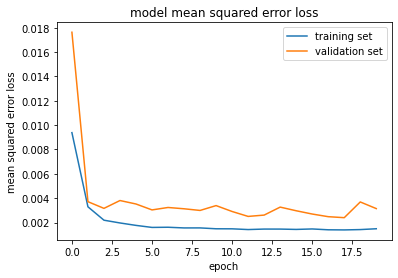

In [11]:
import matplotlib.pyplot  as plt
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model mean squared error loss')
plt.ylabel('mean squared error loss')
plt.xlabel('epoch')
plt.legend(['training set', 'validation set'], loc='upper right')
plt.show()

In [12]:
custom_1.save('model.h5')